<a href="https://colab.research.google.com/github/Aswin-Cheerngodan/AI-ML-books/blob/main/stock_price_model_development_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model development

Try different models like LSTM, GRU, Transformers

Importing dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, GRU, BatchNormalization, Bidirectional
from sklearn.preprocessing import StandardScaler

In [20]:
stock = "microsoft"

In [4]:
df = pd.read_csv("/content/microsoft.csv")
scaler = StandardScaler()

data = df[[ 'Open', 'Close', 'High', 'Low', 'Volume','normalized']].values

split = int(0.95*len(data))
train_data = data[:split]
test_data = data[split:]

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

train_data.shape,test_data.shape

((1471, 6), (78, 6))

In [5]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, 0])

    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

X_train.shape, y_train.shape

((1461, 10, 6), (1461,))

In [6]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=1024, return_sequences=True),
    Dropout(0.1),
    Bidirectional(LSTM(units=512, return_sequences=True)),
    Dropout(0.1),
    LSTM(units=256, return_sequences=True),
    Dropout(0.1),
    Bidirectional(LSTM(units=128, return_sequences=False)),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='tanh'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 1024)            │       4,222,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 1024)            │       6,295,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 256)             │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,331,521 (47.04 MB)

 Trainable params: 12,331,521 (47.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'{stock}_model.keras',
                                                      save_best_only=True,
                                                      monitor='val_loss')

In [30]:
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint] ,
                    verbose=1)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0030 - val_loss: 0.0063
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0034 - val_loss: 0.0193
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0036 - val_loss: 0.0111
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0044 - val_loss: 0.0043


In [45]:
model = tf.keras.models.load_model("/content/microsoft_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
predicted_prices = model.predict(X_train)

def inverse_transform(scaled_data, scaler):
    dummy = np.zeros((len(scaled_data), 6))
    dummy[:, 0] = scaled_data.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [47]:
actual_prices = inverse_transform(y_train, scaler)
predicted_prices = inverse_transform(predicted_prices, scaler)

actual_prices.shape, predicted_prices.shape

((1461,), (1461,))

In [48]:
test_data.shape

(78, 6)

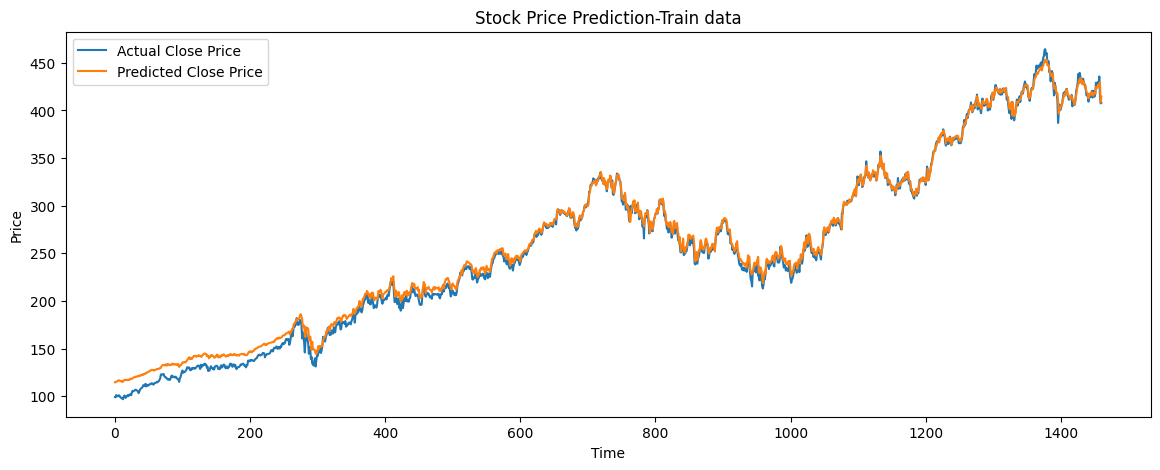

In [49]:
plt.figure(figsize=(14,5))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Stock Price Prediction-Train data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


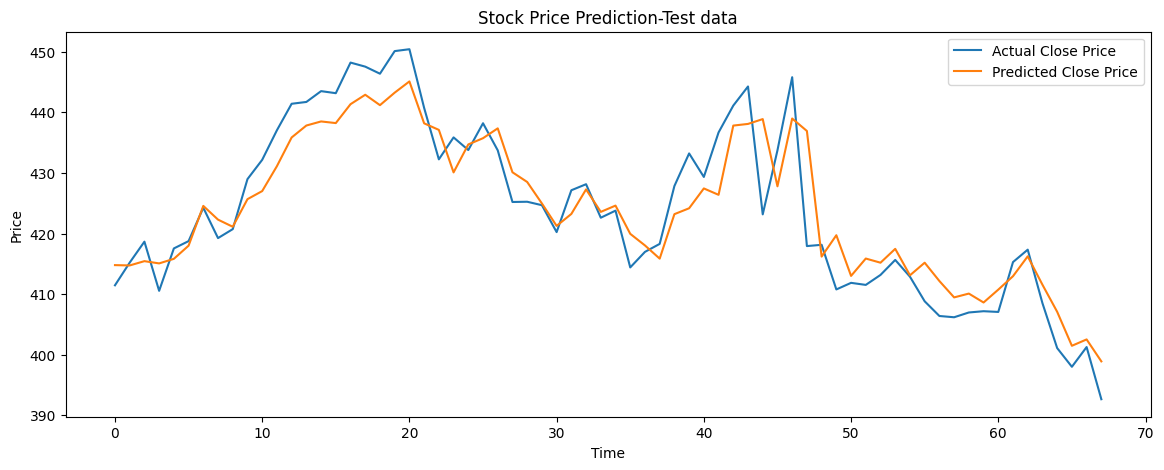

In [50]:
predicted_prices = model.predict(X_test)

actual_prices = inverse_transform(y_test, scaler)
predicted_prices = inverse_transform(predicted_prices, scaler)

plt.figure(figsize=(14,5))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('Stock Price Prediction-Test data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_percentage_error

mse = mean_absolute_percentage_error(actual_prices, predicted_prices)
print(mse)

0.009540365919695775


In [44]:
import joblib

joblib.dump(scaler, f"{stock}_scaler.pkl")

['microsoft_scaler.pkl']